In [1]:
from langgraph.graph import START, END ,StateGraph
from typing import TypedDict
from dotenv import load_dotenv
import os 
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
from typing import Annotated, Sequence
from langgraph.graph.message import add_messages
from pydantic import BaseModel , Field
from langchain_core.messages import HumanMessage , AIMessage , BaseMessage
from langgraph.prebuilt import ToolNode
import json
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
import pandas as pd
import csv
from together import Together

load_dotenv

USER_AGENT environment variable not set, consider setting it to identify your requests.


<function dotenv.main.load_dotenv(dotenv_path: Union[str, ForwardRef('os.PathLike[str]'), NoneType] = None, stream: Optional[IO[str]] = None, verbose: bool = False, override: bool = False, interpolate: bool = True, encoding: Optional[str] = 'utf-8') -> bool>

In [ ]:
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
TOGETHER_API_KEY = os.getenv("TOGETHER_API_KEY")
HUGGING_FACE_API_KEY = os.getenv("HUGGING_FACE_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

In [ ]:
### Use `Gemini` for `Embeddings`

from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001",google_api_key=GEMINI_API_KEY)
embeddings.embed_query("Hello")

[0.04294552654027939,
 0.010022000409662724,
 -0.059493038803339005,
 -0.017845606431365013,
 0.06550341844558716,
 0.013580216094851494,
 0.03284594789147377,
 -0.024407029151916504,
 -0.01197817362844944,
 0.05273199826478958,
 -0.01533560175448656,
 0.02124476246535778,
 -0.027767186984419823,
 0.007765260059386492,
 -0.027406424283981323,
 -0.00823913887143135,
 0.015727350488305092,
 0.023823359981179237,
 0.034681886434555054,
 -0.016957636922597885,
 0.04381808638572693,
 0.01441993284970522,
 -0.0094905449077487,
 0.00520305847749114,
 0.04185013473033905,
 -0.023957407101988792,
 0.01834220439195633,
 -0.03360859304666519,
 -0.0376124307513237,
 0.0072122481651604176,
 -0.04525814950466156,
 0.014033854007720947,
 -0.0364934504032135,
 0.022377481684088707,
 0.02830738201737404,
 -0.058352552354335785,
 -0.006905268412083387,
 0.02415665052831173,
 -0.010028090327978134,
 0.01753859594464302,
 0.007154270075261593,
 -0.051842931658029556,
 -0.044875409454107285,
 0.00311089563

In [6]:
# Getting the urls
'''
"https://emedicine.medscape.com/article/202333-guidelines",    "https://emedicine.medscape.com/article/202333-guidelines",


urls = [
    "https://www.ncbi.nlm.nih.gov/books/NBK499994/",
    "https://www.webmd.com/a-to-z-guides/complete-blood-count",
    "https://www.medicalnewstoday.com/articles/is-anemia-dangerous#overall-outlook",
    "https://pmc.ncbi.nlm.nih.gov/articles/PMC11247274/",
    "https://www.ncbi.nlm.nih.gov/books/NBK499994/"
]

rbcs_url =[WebBaseLoader(url).load() for url in urls]
rbcs_docs = [item for url in rbcs_url for item in url]
rbcs_docs
'''


import os
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.text_splitter import TokenTextSplitter


# Set path to the folder containing PDFs
folder_path = "./RAG/"

# Initialize an empty list to collect all chunks
all_chunks = []

# Loop over all PDF files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".pdf"):
        file_path = os.path.join(folder_path, filename)
        loader = PyPDFLoader(file_path)
        docs = loader.load()

        # Split each document into chunks
        #splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)
        #chunks = splitter.split_documents(docs)
        #all_chunks.extend(chunks)

# Split by number of tokens instead of characters
        splitter = TokenTextSplitter(chunk_size=500, chunk_overlap=50)

        token_chunks = splitter.split_documents(docs)
        all_chunks.extend(token_chunks)

# all_chunks now contains all PDF text chunks from the RAG folder
print(f"Total chunks: {len(all_chunks)}")


Total chunks: 122


In [7]:
rbcs_docs = all_chunks
rbcs_docs

[Document(metadata={'producer': 'Skia/PDF m138', 'creator': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/138.0.0.0 Safari/537.36 Edg/138.0.0.0', 'creationdate': '2025-07-13T16:30:28+00:00', 'title': 'Anemia: Is it dangerous and how to treat it', 'moddate': '2025-07-13T16:30:28+00:00', 'source': './RAG/Anemia_ Is it dangerous and how to treat it.pdf', 'total_pages': 17, 'page': 0, 'page_label': '1'}, page_content='Anemia: How dangerous is it?\nMedically reviewed by Avi Varma, MD, MPH, AAHIVS, FAAFP — Written by\nCaitlin Geng — Updated on June 2, 2025\nMild anemia is typically treatable. However, some types of\nanemia, such as thalassemia and aplastic anemia, are\nmore severe and can be life threatening.\nAnemia occurs when the blood does not contain enough healthy red\nblood cells. As red blood cells carry oxygen around the body, anemia\nmeans the body does not receive adequate oxygen through the blood.\nThis article looks at whether anemia is

In [104]:
result

'There is no medical document provided, only a webpage from the National Library of Medicine (NLM). Therefore, there are no CBC parameters, anemia, or blood disorders to summarize. The webpage appears to be a general information page for the NLM, with links to various resources and social media platforms, but it does not contain any specific medical information or data.'

In [8]:
print(rbcs_docs[2].page_content)

In severe cases, aplastic anemia can lead to complications such as heart
failure, leukemia, bleeding, and other blood disorders.
Hemolytic anemia
Hemolytic anemia occurs when the body destroys oxygen-carrying red
blood cells faster than it can replace them.
The body typically destroys old red blood cells it no longer requires
through hemolysis. However, if too much hemolysis occurs, the body will
have insufficient red blood cells.
Severe hemolytic anemia can lead to potentially fatal complications,
such as heart failure.
Sickle cell anemia
Sickle cell anemia is a type of hemolytic anemia in which a person’s
hemoglobin protein is abnormal. This can cause red blood cells to
become inflexible, causing them to become distinctly sickle-shaped.
The cells may then become lodged and block blood flow to the organs.
In severe cases, sickle cell anemia can lead to disability and life
threatening complications, such as organ damage.
Fanconi anemia
Fanconi anemia is a rare genetic disorder that ca

In [24]:
loader.load()[0].page_content

'Iron Deficiency Anemia Guidelines\nUpdated: Aug 23, 2023\n- Author: James L Harper, MD; Chief Editor: Emmanuel C Besa, MD\xa0 more...\n- Share\n- Print\n- Feedback\n- Facebook\n- Twitter\n- LinkedIn\n- WhatsApp\n- Email'

In [126]:
len(all_chunks)

122

In [ ]:
'''
splitter = RecursiveCharacterTextSplitter(chunk_size= 2000 , chunk_overlap = 200)
splitting_texts = splitter.split_documents(rbcs_docs)
len(splitting_texts)
rbcs_docs = splitting_texts
rbcs_docs
'''

[Document(metadata={'producer': 'Skia/PDF m138', 'creator': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/138.0.0.0 Safari/537.36 Edg/138.0.0.0', 'creationdate': '2025-07-13T16:30:28+00:00', 'title': 'Anemia: Is it dangerous and how to treat it', 'moddate': '2025-07-13T16:30:28+00:00', 'source': './RAG/Anemia_ Is it dangerous and how to treat it.pdf', 'total_pages': 17, 'page': 0, 'page_label': '1'}, page_content='Anemia: How dangerous is it?\nMedically reviewed by Avi Varma, MD, MPH, AAHIVS, FAAFP — Written by\nCaitlin Geng — Updated on June 2, 2025\nMild anemia is typically treatable. However, some types of\nanemia, such as thalassemia and aplastic anemia, are\nmore severe and can be life threatening.\nAnemia occurs when the blood does not contain enough healthy red\nblood cells. As red blood cells carry oxygen around the body, anemia\nmeans the body does not receive adequate oxygen through the blood.\nThis article looks at whether anemia is

In [ ]:
from langchain_together import ChatTogether
model = ChatTogether(
    together_api_key=TOGETHER_API_KEY,
    model="meta-llama/Llama-3-70b-chat-hf"
)
model

ChatTogether(client=<openai.resources.chat.completions.completions.Completions object at 0x000001B5B4C148F0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000001B5B5021010>, model_name='meta-llama/Llama-3-70b-chat-hf', model_kwargs={}, together_api_key=SecretStr('**********'), together_api_base='https://api.together.xyz/v1/')

In [127]:
len(rbcs_docs)

122

In [ ]:
import uuid

from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

from langchain_core.prompts import ChatPromptTemplate

cbc_insight_summary_prompt = ChatPromptTemplate.from_template("""
You are a professional medical analyst and hematology expert. Analyze the following document related to Complete Blood Count (CBC), anemia, or blood disorders.

Your task is to:
- Identify and concisely summarize any abnormalities in CBC parameters (e.g., low Hemoglobin, high MCV, low Platelets) if explicitly stated.
- Mention any named or strongly implied types of anemia or blood disorders (e.g., iron deficiency anemia, microcytic anemia, hemolytic anemia).
- Include any treatment or management recommendations that are clearly stated.

❗️Important:
- If there are NO mentions of CBC parameters, NO types of anemia, and NO blood disorders, and no relevant medical content, you MUST return exactly: None
- Do NOT explain or describe why content is missing. Do NOT output anything else. Just return: None
- Do NOT summarize general information, introductions, or website/legal content. Only summarize if actual medical findings, terminology, or recommendations are present.

Write a medically accurate, direct summary in a single paragraph with no preamble.

Document:

{rbcs_docs}
""")




chain = (
    {"rbcs_docs": lambda x: x.page_content}
    | cbc_insight_summary_prompt
    | model
    | StrOutputParser()
)
import time

summaries = []

for i, doc in enumerate(rbcs_docs):
    try:
        result = chain.invoke(doc)
        summaries.append(result)
        print(f"✅ Done {i+1}/{len(rbcs_docs)}")
        time.sleep(2)  # avoid hitting rate limit
    except Exception as e:
        print(f"❌ Error on doc {i+1}: {e}")
        time.sleep(20)  # wait longer after failure


#summaries = chain.batch(splitting_texts)


✅ Done 1/122
✅ Done 2/122
✅ Done 3/122
✅ Done 4/122
✅ Done 5/122
✅ Done 6/122
✅ Done 7/122
✅ Done 8/122
✅ Done 9/122
✅ Done 10/122
✅ Done 11/122
✅ Done 12/122
✅ Done 13/122
✅ Done 14/122
✅ Done 15/122
✅ Done 16/122
✅ Done 17/122
✅ Done 18/122
✅ Done 19/122
✅ Done 20/122
✅ Done 21/122
✅ Done 22/122
✅ Done 23/122
✅ Done 24/122
✅ Done 25/122
✅ Done 26/122
✅ Done 27/122
✅ Done 28/122
✅ Done 29/122
✅ Done 30/122
✅ Done 31/122
✅ Done 32/122
✅ Done 33/122
✅ Done 34/122
✅ Done 35/122
✅ Done 36/122
✅ Done 37/122
✅ Done 38/122
✅ Done 39/122
✅ Done 40/122
✅ Done 41/122
✅ Done 42/122
✅ Done 43/122
✅ Done 44/122
✅ Done 45/122
✅ Done 46/122
✅ Done 47/122
✅ Done 48/122
✅ Done 49/122
✅ Done 50/122
✅ Done 51/122
✅ Done 52/122
✅ Done 53/122
✅ Done 54/122
✅ Done 55/122
✅ Done 56/122
✅ Done 57/122
✅ Done 58/122
✅ Done 59/122
✅ Done 60/122
✅ Done 61/122
✅ Done 62/122
✅ Done 63/122
✅ Done 64/122
✅ Done 65/122
✅ Done 66/122
✅ Done 67/122
✅ Done 68/122
✅ Done 69/122
✅ Done 70/122
✅ Done 71/122
✅ Done 72/122
✅

In [11]:
summaries 

['Thalassemia and aplastic anemia are mentioned as severe and potentially life-threatening types of anemia; no specific CBC parameter abnormalities or treatment recommendations are stated.',
 'Here is a medically accurate summary of the document:\n\nThe document mentions iron-deficiency anemia as the most common type of anemia, and notes that severe thalassemia and aplastic anemia are life-threatening forms of anemia. In thalassemia, the body does not produce enough hemoglobin, leading to red blood cell dysfunction and death, resulting in complications and potentially death due to heart failure and irregular heart rhythm. No specific CBC parameter abnormalities are mentioned.',
 'Aplastic anemia, hemolytic anemia, sickle cell anemia, and Fanconi anemia are mentioned, with potential complications including heart failure, bleeding, leukemia, organ damage, and acute myeloid leukemia.',
 'Iron-deficiency anemia is mentioned, with a good outlook if treated, but potentially life-threatening 

In [12]:
filtered_summaries = [summary for summary in summaries if summary.strip().lower() != "none"]
len(filtered_summaries)

109

In [13]:
docs = rbcs_docs
docs


[Document(metadata={'producer': 'Skia/PDF m138', 'creator': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/138.0.0.0 Safari/537.36 Edg/138.0.0.0', 'creationdate': '2025-07-13T16:30:28+00:00', 'title': 'Anemia: Is it dangerous and how to treat it', 'moddate': '2025-07-13T16:30:28+00:00', 'source': './RAG/Anemia_ Is it dangerous and how to treat it.pdf', 'total_pages': 17, 'page': 0, 'page_label': '1'}, page_content='Anemia: How dangerous is it?\nMedically reviewed by Avi Varma, MD, MPH, AAHIVS, FAAFP — Written by\nCaitlin Geng — Updated on June 2, 2025\nMild anemia is typically treatable. However, some types of\nanemia, such as thalassemia and aplastic anemia, are\nmore severe and can be life threatening.\nAnemia occurs when the blood does not contain enough healthy red\nblood cells. As red blood cells carry oxygen around the body, anemia\nmeans the body does not receive adequate oxygen through the blood.\nThis article looks at whether anemia is

In [199]:
len(docs)

122

In [197]:
len(summaries)

122

In [14]:
from langchain.storage import InMemoryByteStore
from langchain_community.vectorstores import Chroma
from langchain.retrievers.multi_vector import MultiVectorRetriever

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="summaries",
                     embedding_function=embeddings)

# The storage layer for the parent documents
store = InMemoryByteStore()
id_key = "doc_id"

# The retriever
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key,
)
doc_ids = [str(uuid.uuid4()) for _ in docs]

# Docs linked to summaries
summary_docs = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(summaries)
]

# Add
retriever.vectorstore.add_documents(summary_docs)
retriever.docstore.mset(list(zip(doc_ids, docs)))

C:\Users\omark\AppData\Local\Temp\ipykernel_28116\2940846793.py:6: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(collection_name="summaries",


In [15]:
summary_docs

[Document(metadata={'doc_id': 'b768fa36-39d4-4c49-b36f-b7cae8c550eb'}, page_content='Thalassemia and aplastic anemia are mentioned as severe and potentially life-threatening types of anemia; no specific CBC parameter abnormalities or treatment recommendations are stated.'),
 Document(metadata={'doc_id': 'e0431476-2cab-406b-978c-f7fefffd8612'}, page_content='Here is a medically accurate summary of the document:\n\nThe document mentions iron-deficiency anemia as the most common type of anemia, and notes that severe thalassemia and aplastic anemia are life-threatening forms of anemia. In thalassemia, the body does not produce enough hemoglobin, leading to red blood cell dysfunction and death, resulting in complications and potentially death due to heart failure and irregular heart rhythm. No specific CBC parameter abnormalities are mentioned.'),
 Document(metadata={'doc_id': 'd2ea7168-ce89-46b6-8881-4d8d26de50fd'}, page_content='Aplastic anemia, hemolytic anemia, sickle cell anemia, and F

In [16]:
summary_docs

[Document(metadata={'doc_id': 'b768fa36-39d4-4c49-b36f-b7cae8c550eb'}, page_content='Thalassemia and aplastic anemia are mentioned as severe and potentially life-threatening types of anemia; no specific CBC parameter abnormalities or treatment recommendations are stated.'),
 Document(metadata={'doc_id': 'e0431476-2cab-406b-978c-f7fefffd8612'}, page_content='Here is a medically accurate summary of the document:\n\nThe document mentions iron-deficiency anemia as the most common type of anemia, and notes that severe thalassemia and aplastic anemia are life-threatening forms of anemia. In thalassemia, the body does not produce enough hemoglobin, leading to red blood cell dysfunction and death, resulting in complications and potentially death due to heart failure and irregular heart rhythm. No specific CBC parameter abnormalities are mentioned.'),
 Document(metadata={'doc_id': 'd2ea7168-ce89-46b6-8881-4d8d26de50fd'}, page_content='Aplastic anemia, hemolytic anemia, sickle cell anemia, and F

In [202]:
doc_ids

['514ca621-8799-4ece-89b6-9d2620b9412f',
 '81e24c5a-2ff0-4f45-b99f-60d38be88af0',
 '59153b5a-02f0-411b-9abf-2c328f2e0efb',
 '4be5f698-bc8b-4b76-9846-a170d3c47434',
 'e40b6e4b-5041-4b64-a049-a1c9a723d58b',
 '23ea12b5-1222-4f72-bf95-5059477e8f7a',
 'b2a6d190-b27e-45cd-a9f2-453abf24ce47',
 'a06520f1-f054-499c-96d1-c31fa40659c6',
 'c05f2cd2-6ce9-4478-85d6-2cb403c870fb',
 'c37b94e1-dff8-4646-a8f9-8a7454a334ee',
 'cb96dc82-2110-4d4c-aa48-c33651dc2e41',
 '61b2d8bc-104a-4eb6-a75b-3bf0714a5874',
 '1a0e7e1d-469b-4062-b7b5-9f4afd48cb5a',
 'f63f8876-84b2-4502-8a10-82d022c3bd13',
 'c7519cb9-c7d0-4477-b5d1-142bdc2154cd',
 'f2f55a4b-a9ee-4b24-9d7a-bb436f3f1540',
 'aa37784f-afdb-49f3-8a48-1b8056f8cf46',
 '7049dc20-63fa-4e02-9ff0-a99c254965d3',
 'cc73bd8e-0ee9-43ee-af39-1cfe4316f66f',
 'fb8e0b4c-4673-4b9d-8808-20efe4f432eb',
 'a5fdda1b-bea8-47f2-bbb2-ecea711629e2',
 '200f13b2-8120-47c8-ad2f-3b140d559225',
 'a1ee88df-c394-4302-9569-e1cc9a477b06',
 'e57f28ee-b38b-4090-9175-2e6db3d37100',
 'f9db26f7-ceae-

🔹 `vectorstore.similarity_search(query)`
✅ Searches only the vectorized summaries (child docs).

✅ Returns those summary chunks (e.g., sentences or paragraphs).

❌ Does not give you the full original documents.

🔹 `retriever.invoke(query)` with MultiVectorRetriever
✅ Performs similarity search on the summaries (same as above).

✅ Then uses doc_id in metadata to fetch the full parent document from the byte store.

✅ Returns the original document(s) related to the most relevant summaries.

✅ Summary in One Line:
vectorstore.similarity_search() returns relevant summaries,
retriever.invoke() returns full documents related to those summaries.

In [17]:
retriever.invoke("what is anemia ?")

[Document(metadata={'producer': 'Skia/PDF m126', 'creator': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) obsidian/1.7.4 Chrome/126.0.6478.234 Electron/31.6.0 Safari/537.36', 'creationdate': '2025-07-13T16:32:53+00:00', 'title': 'RAG CBC - Obsidian Vault - Obsidian v1.8.10', 'moddate': '2025-07-13T16:32:53+00:00', 'source': './RAG/RAG CBC.pdf', 'total_pages': 40, 'page': 19, 'page_label': '20'}, page_content='Continuing Education Activity\nAnemia is a reduction in hemoglobin (Hb) or hematocrit (HCT) or RBC count. It is a\npresentation of an underlying condition and can be subdivided into macrocytic,\nmicrocytic, or normocytic. Patients with anemia typically present with vague\nsymptoms such as lethargy, weakness, and tiredness. Severe anemia may present\nwith syncope, shortness of breath, and reduced exercise tolerance. This activity\noutlines the evaluation and treatment of anemia and explains the role of the\ninterprofessional team in managing pati

In [210]:
query = "what is microcytic hypochromic anemia"
sub_docs = vectorstore.similarity_search(query,k=5)
sub_docs

[Document(metadata={'doc_id': 'a06520f1-f054-499c-96d1-c31fa40659c6'}, page_content='Microcytic anemia is characterized by small red blood cells with low hemoglobin, leading to inadequate oxygen delivery to tissues and organs; symptoms may include pale skin, grayish color inside eyelids or under nails, and may be discovered incidentally on a blood test, with no specific treatment or management recommendations mentioned.'),
 Document(metadata={'doc_id': 'e59b0f57-c28b-41f3-9d53-6fa7a023a79a'}, page_content='Microcytic anemia is characterized by small red blood cells with low hemoglobin, leading to inadequate oxygen delivery to tissues and organs; symptoms may include pale skin, grayish color inside eyelids or under nails, and may be discovered incidentally on a blood test, with no specific treatment or management recommendations mentioned.'),
 Document(metadata={'doc_id': 'ee0f7b2a-be9d-4f6d-ad15-3f47e6e3001d'}, page_content='Hypochromic microcytic anemia is implied, characterized by lo

In [140]:
retrieved_docs = retriever.invoke(query)
retrieved_docs

[Document(metadata={'source': 'https://pmc.ncbi.nlm.nih.gov/articles/PMC11247274/', 'title': '\n            Recommendations for diagnosis, treatment, and prevention of iron deficiency and iron deficiency anemia - PMC\n        ', 'description': 'Iron is an essential nutrient and a constituent of ferroproteins and enzymes crucial for human life. Generally, nonmenstruating individuals preserve iron very efficiently, losing less than 0.1% of their body iron content each day, an amount that is ...', 'language': 'en'}, page_content='NCBI RSS feed\n\n\n\n\n\n\n\n                            Connect with NLM\n                        \n\n\n\n\n\n\nNLM on X (formerly known as Twitter)\n\n\n\n\n\n\nNLM on Facebook\n\n\n\n\n\nNLM on YouTube\n\n\n\n\n\nNational Library of Medicine\n             8600 Rockville Pike Bethesda, MD 20894\n\n\n\n\n\n    \n\n    Web Policies\n\n    \n\n\n\n\n    \n\n    FOIA\n\n    \n\n\n\n\n    \n\n    HHS Vulnerability Disclosure\n\n    \n\n\n\n\n\n\n    \n\n    Help\n\n

In [157]:
print(retrieved_docs[3].page_content)


and hematocrit. RBC are produced in the bone marrow and released into circulation. Approximately 1% of RBC are removed from circulation per day. Imbalance in production to removal or destruction of RBC leads to anemia. [5]The main mechanisms involved in anemia are listed below:1. Increased RBC destructionBlood loss


In [223]:
retriever.invoke("Since there is a deficiency in RBCs, Hemoglobin, and HCT, along with low Neutrophils, the findings are consistent with Normocytic Normochromic Anemia, likely due to chronic inflammation or bone marrow dysfunction, and Neutropenia, which may indicate a compromised immune system.")

[Document(metadata={'producer': 'Skia/PDF m126', 'creator': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) obsidian/1.7.4 Chrome/126.0.6478.234 Electron/31.6.0 Safari/537.36', 'creationdate': '2025-07-13T16:32:53+00:00', 'title': 'RAG CBC - Obsidian Vault - Obsidian v1.8.10', 'moddate': '2025-07-13T16:32:53+00:00', 'source': './RAG/RAG CBC.pdf', 'total_pages': 40, 'page': 7, 'page_label': '8'}, page_content='Lethargy\nRestless legs\nShortness of breath, especially on exertion, near syncope\nChest pain and reduced exercise tolerance- with more severe anemia\nPica- desire to eat unusual and nondietary substances\xa0\nMild anemia may otherwise be asymptomatic\xa0\n2. Signs of anemia\nSkin may be cool to touch\nTachypnea\nHypotension (orthostatic)\nHEENT:\nPallor of the conjunctiva\xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \x

# RAG

In [18]:
from typing import List , TypedDict , NotRequired


class State(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]

    #messages:Annotated[Sequence[list],add_messages]
    summary:NotRequired[str]
    # For generating the report and save it
    file_path:str
    processing_result : NotRequired[str]
    json_filename : NotRequired[str]
    csv_filename: NotRequired[str]
    data_csv_format :NotRequired[str]
    is_relevant:NotRequired[str]
    
    
    # For checking report
    majority_voting:NotRequired[str]
    reason:NotRequired[str]

    # QQuestion and Answer
    #question : NotRequired[str]
    #answer : NotRequired[str]

In [ ]:

    
import fitz  # PyMuPDF
from pydantic import BaseModel, Field
from typing import Optional
from langchain.chat_models import ChatOpenAI

def processing_pdf(state:State):
    print(f"----File path :{state["file_path"]}")
    file_path = state["file_path"]

        # 1️⃣ Utility: Extract text from PDF
    def extract_text_from_pdf(file_path: str) -> str:
        doc = fitz.open(file_path)
        return "\n".join(page.get_text() for page in doc)

    # 2️⃣ Data models

    class TestResult(BaseModel):
        result: str = Field(..., description="Measured value of the test")
        unit: str = Field(..., description="Unit of measurement")
        reference_range: str = Field(..., description="Normal reference range")

    class CBCPanel(BaseModel):
        rbc: TestResult = Field(..., description="Red Blood Cells count – indicates oxygen-carrying capacity of blood")
        hemoglobin: TestResult = Field(..., description="Hemoglobin level – main protein in RBCs, carries oxygen")
        hct: TestResult = Field(..., description="Hematocrit – percentage of blood volume occupied by red blood cells")
        mcv: TestResult = Field(..., description="Mean Corpuscular Volume – average size of red blood cells")
        mch: TestResult = Field(..., description="Mean Corpuscular Hemoglobin – average amount of hemoglobin per RBC")
        mchc: TestResult = Field(..., description="Mean Corpuscular Hemoglobin Concentration – hemoglobin concentration in RBCs")
        plt: TestResult = Field(..., description="Platelets – involved in blood clotting")
        tlc: TestResult = Field(..., description="Total Leucocytic Count – total white blood cells in circulation")
        rdw_cv: TestResult = Field(..., description="Red Cell Distribution Width (CV) – variation in RBC size")
        pdw: TestResult = Field(..., description="Platelet Distribution Width – variation in platelet size")
        mpv: TestResult = Field(..., description="Mean Platelet Volume – average size of platelets")
        staff: TestResult = Field(..., description="Staff cells – immature neutrophils; increase during infections")
        segmented: TestResult = Field(..., description="Segmented neutrophils – mature neutrophils; first responders to infection")
        neutrophils: TestResult = Field(..., description="Neutrophils – fight bacteria and fungi")
        lymphocytes: TestResult = Field(..., description="Lymphocytes – defend against viruses")
        monocytes: TestResult = Field(..., description="Monocytes – remove dead cells and pathogens")
        eosinophils: TestResult = Field(..., description="Eosinophils – respond to parasites/allergies")
        basophils: TestResult = Field(..., description="Basophils – release histamine during allergic reactions")

    class PatientInfo(BaseModel):
        patient_name: str = Field(..., description="Full name of the patient")
        lab_name: str = Field(..., description="Name of the lab or laboratory branch")
        lab_number: str = Field(..., description="Unique Lab Number for the test")
        patient_number: str = Field(..., description="Unique patient identifier")
        age: str = Field(..., description="Patient age in years")
        sex: str = Field(..., description="Patient biological sex")
        request_date: str = Field(..., description="Date and time when the test was requested")
        print_date: str = Field(..., description="Date and time when the report was printed")

    class FullLabReport(BaseModel):
        patient_info: PatientInfo = Field(..., description="Basic patient and lab information")
        cbc_panel: CBCPanel = Field(..., description="Complete Blood Count test results")
        comments: str = Field(..., description="Interpretation and remarks from the lab report")

    # 3️⃣ Load model (ensure OpenAI API key is set)
    model = ChatGoogleGenerativeAI(model="gemini-2.0-flash-001", api_key=GEMINI_API_KEY).with_structured_output(FullLabReport)

    # 4️⃣ Load and read PDF
    # pdf_path = "./cbc_report.pdf"  # Replace with your actual file
    raw_text = extract_text_from_pdf(file_path)

    # 5️⃣ Prompt template
    prompt = f"""
    You are a medical document extraction system.

    This is a hematology report that contains:
    1. Patient and lab metadata (e.g., patient name, age, gender, lab number, request date)
    2. A CBC test panel (Complete Blood Count)
    3. A comments section starting with 'Comments :-' and listing interpretations

    💡 The report structure is irregular:
    - Test names (e.g., RBC, MCH, etc.) appear first
    - Then a list of test results
    - Then the units
    - Then the reference ranges
    - Patient metadata is at the end
    - Comments section starts with "Comments :- , and ends it with the last sentence form "

    🔧 Instructions:
    - Match test names with their result, unit, and reference range **by order**, not by proximity.
    - Ignore noise such as `*`, formatting issues, or duplication.
    - Extract the entire comment block starting from `Comments :-` as one string.
    - Output:
    - `patient_info`: includes patient name, lab name, age, sex, patient number, lab number, request date, print date
    - `cbc_panel`: contains full CBC values as defined
    - `comments`: full interpretation remarks starting from 'Comments :-'

    Report:
    {raw_text}
    """

    # 6️⃣ Invoke the model
    result = model.invoke(prompt)
        # 7️⃣ Output
    #print("\n✅ Patient Info:")
    #print(result.patient_info)

    #print("\n🩸 CBC Panel:")
    #print(result.cbc_panel)

    #print("\n📝 Comments:")
   # print(result.comments)

    return {"processing_result" : result}







In [20]:

def saving_json(state:State):
    print(f"----- Saving into JSON -----")

    result = state["processing_result"]

    filename = state.get("json_filename", "cbc_output.json")

    def save_llm_output_to_json(result, filename):
        report_dict = result.model_dump()

        if os.path.exists(filename):
            with open(filename, "r", encoding="utf-8") as f:
                existing_data = json.load(f)

            # Ensure existing data is a list
            if not isinstance(existing_data, list):
                existing_data = [existing_data]

            existing_data.append(report_dict)

            with open(filename, "w", encoding="utf-8") as f:
                json.dump(existing_data, f, ensure_ascii=False, indent=2)

        else:
            # First-time create
            with open(filename, "w", encoding="utf-8") as f:
                json.dump([report_dict], f, ensure_ascii=False, indent=2)

    save_llm_output_to_json(result=result,filename=filename)

In [21]:

def save_csv(state:State):
    print(f"----- Saving into CSV -----")

    report = state["processing_result"]
    filename = state.get("csv_filename" , "cbc_reports.csv")
    
    def flatten_report(report) -> dict:
        data = {}

        # Patient Info
        for field, value in report.patient_info.model_dump().items():
            data[f"patient_{field}"] = value

        # CBC Panel
        for field, test in report.cbc_panel.model_dump().items():
            result = test["result"].lstrip("*").strip()
            data[f"{field}_result"] = result
            data[f"{field}_unit"] = test["unit"].strip()
            data[f"{field}_reference_range"] = test["reference_range"].strip()

        # Comments
        data["comments"] = report.comments.strip()

        return data
        #return {"data_csv_format" : data}

    def save_report_to_csv(report, filename):
        #row_data = flatten_report(report)
        #row_data = flatten_report(report)


        df = pd.DataFrame([report])
        

        # If file exists, append without header
        if os.path.exists(filename):
            df.to_csv(
                filename,
                mode="a",
                index=False,
                header=False,
                encoding="utf-8-sig",
                quoting=csv.QUOTE_ALL
            )
        else:
            # Create new CSV with header
            df.to_csv(
                filename,
                index=False,
                encoding="utf-8-sig",
                quoting=csv.QUOTE_ALL
            )

    #save_report_to_csv(report , filename=filename)
    flat_data = flatten_report(report)
    save_report_to_csv(flat_data, filename)

    return {"data_csv_format": flat_data}

In [ ]:
import os
import fitz
from pydantic import BaseModel, Field

def is_cbc_report(state: State):

    file_path = state["file_path"]

    print(f"----Checking the Report at: {file_path} ---- \n")

    # ✅ Check if the file exists
    if not os.path.isfile(file_path):
        print("❌ Error: File not found.")
        return {
            "is_relevant": "no",
            "reason": f"File not found at path: {file_path}"
        }

    # 1️⃣ Utility: Extract text from PDF
    def extract_text_from_pdf(file_path: str) -> str:
        doc = fitz.open(file_path)
        return "\n".join(page.get_text() for page in doc)

    # 2️⃣ Schema for structured output
    class Grade(BaseModel):
        is_relevant: str = Field(description="Is that file a CBC report? Just answer 'yes' or 'no'")
                
        reason: str = Field(description="Why you think it is or isn't a CBC report")

    # 3️⃣ Use your existing model
    model = ChatGoogleGenerativeAI(model="gemini-2.0-flash-001", api_key=GEMINI_API_KEY).with_structured_output(Grade)

    # 4️⃣ Extract text
    raw_text = extract_text_from_pdf(file_path)

    # 5️⃣ Prompt
    prompt = f""" 
    You are a medical document classification assistant.

    See this report and determine if it's a CBC report or not.

    A valid CBC report must include these parameters:
    - RBCs
    - Hemoglobin (Hb)
    - HCT
    - MCV
    - MCH
    - MCHC
    - Platelets count
    - Leukocytes count

    Just return 'yes' or 'no'.

    Report text:
    {raw_text}
    """

    # 6️⃣ Invoke model
    result = model.invoke(prompt)

    # 7️⃣ Return result
    return {
        "is_relevant": result.is_relevant,
        "reason": result.reason
    }


In [23]:
def should_continue(state:State):
    score = state['is_relevant']

    if score =="yes":
        return "cbc_report"
    else:
        return "not_cbc"

In [32]:
from langchain_core.messages import SystemMessage

def summarize_report(state: State):
    print(f"--- Summarizing Step ---")
    raw_json = state["data_csv_format"]
    json_input = json.dumps(raw_json, indent=2)

    prompt = f"""
You are a professional medical analyst and hematology expert reviewing a patient's Complete Blood Count (CBC) report in structured JSON format.

Your task is to:
1. Analyze the CBC parameters.
2. Identify any abnormalities (values outside the reference ranges).
3. Based strictly on these abnormalities, suggest **possible** types of anemia or blood disorders **if supported by the data**.
4. Your response must stay **within the scope of the provided values only**. **Do not speculate** about causes like bone marrow dysfunction or immune system status unless explicitly indicated by the values.
5. Summarize the result in one medically sound paragraph, following this pattern:

"Since there is a deficiency in [list abnormal terms], the findings may indicate [supported diagnosis or classification, such as 'Normocytic Anemia' or 'Microcytic Hypochromic Anemia']."

**Do not provide treatment advice, clinical recommendations, or unrelated medical assumptions. Focus only on what's evident in the values.**

Here is the CBC report data (JSON):
{json_input}
"""
        
    
    response = model.invoke(prompt)
    return {"summary": [response.content]}


In [ ]:
### Retrieval Grader

from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_together import ChatTogether
from pydantic import BaseModel, Field
from collections import Counter


def grade_documents(state:State):
    
    summary = state["question"]
    # Data model
    class GradeDocuments(BaseModel):
        """Binary score for relevance check on retrieved documents."""

        binary_score: str = Field(
            description="Documents are relevant to the question, 'yes' or 'no'"
        )

    # LLM with function call
    llm = ChatTogether(together_api_key=TOGETHER_API_KEY,model="meta-llama/Llama-3-70b-chat-hf")
    structured_llm_grader = llm.with_structured_output(GradeDocuments)

    # Prompt
    system = """
    You are a grader assessing the relevance of a retrieved document to a user question. 
    If the document contains keywords or conveys semantic meaning related to the question, mark it as relevant. 
    Otherwise, mark it as not relevant. 
    Return only 'yes' or 'no' as the score in the binary_score field.
    """

    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
        ]
    )
    ##chain the prompt with the LLM
    retrieval_grader = grade_prompt | structured_llm_grader
    question = summary
    # retrieving from multi-index
    docs = retriever.invoke(question)

    graded_results = []
    votes = []

    for doc in docs:
        result = retrieval_grader.invoke({
            "question": question,
            "document": doc.page_content
        })
        score = result.binary_score.lower().strip()
        votes.append(score)
        graded_results.append({
            "document": doc.page_content,
            "binary_score": score
        })

    # Majority voting
    counts = Counter(votes)
    majority_vote = counts.most_common(1)[0][0] if votes else "no"
    yes_count = votes.count("yes")
    no_count = votes.count("no")


    print(f"Majority Voting is : {majority_vote} , where Number of Relevant Documents = {yes_count} , Number of irrelevant documents = {no_count} , total number of retrieved documents = {len(votes)}")

    if majority_vote == "yes":
        print("---- The retrieved Document is releated to the Question ---")
    else:
        print("---- The retrieved Document is NOT releated to the Question ---")

    # Return updated state
    return {
        "summary": question,
        "graded_documents": graded_results,
        "majority_voting": majority_vote
    }

#    print(retrieval_grader.invoke({"question": summary, "document": doc_txt}))
    #return {"question" : state["summary"] , "document" : state["documents"]}

In [ ]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatTogether(together_api_key=TOGETHER_API_KEY,model="meta-llama/Llama-3-70b-chat-hf",temperature=0)


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
#generation = rag_chain.invoke({"context": docs, "question": question})
#print(generation)

d:\ITI\DS Track\LLMs\Projects\AgenticAi\.venv\Lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [ ]:
### Question Re-writer
'''
# LLM
llm = ChatTogether(together_api_key=together_api,model="meta-llama/Llama-3-70b-chat-hf",temperature=0)

system = """You are a question re-writer that improves user questions to make them more effective for web search.
Only return the rewritten question — do not include any explanation or introduction."""


re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})
'''

'What are the causes, symptoms, and treatment options for anemia?'

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3 , tavily_api_key = TAVILY_API_KEY)


C:\Users\omark\AppData\Local\Temp\ipykernel_28116\1473166490.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  web_search_tool = TavilySearchResults(k=3 , tavily_api_key = "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")


In [ ]:
from langchain.schema import Document


def retrieve(state:State):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["summary"][0]
    print(f"The question : {question}")
    # Retrieval
    documents = retriever.invoke(question)
    print(f"documents : {documents}")
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatTogether(together_api_key=TOGETHER_API_KEY,model="meta-llama/Llama-3-70b-chat-hf",temperature=0)


    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)
    
    docs = format_docs(documents)


    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # RAG generation
    generation = rag_chain.invoke({"context": docs, "question": question})
    return {"documents": docs, "question": question, "generation": generation}





def transform_query(state:State):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    llm = ChatTogether(together_api_key=TAVILY_API_KEY,model="meta-llama/Llama-3-70b-chat-hf",temperature=0)

    system = """You are a question re-writer that improves user questions to make them more effective for web search.
    Only return the rewritten question — do not include any explanation or introduction."""


    re_write_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            (
                "human",
                "Here is the initial question: \n\n {question} \n Formulate an improved question.",
            ),
        ]
    )
    print(f"---- ReWriting question : {re_write_prompt}")

    question_rewriter = re_write_prompt | llm | StrOutputParser()

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents, "question": question}


### Edges


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    majority_voting = state["majority_voting"]
    state["documents"]

    if majority_voting == "no":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

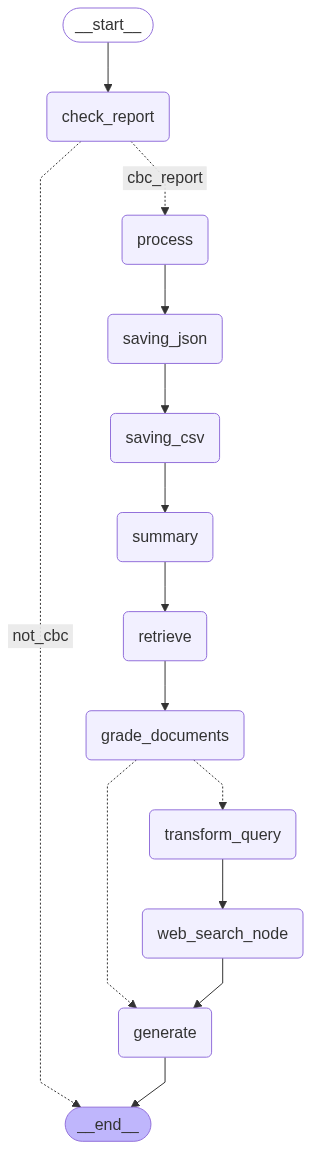

In [33]:
from langgraph.graph import END, StateGraph, START

graph = StateGraph(State)

# Define the nodes
graph.add_node("check_report" , is_cbc_report)

graph.add_node("process" , processing_pdf)
graph.add_node("saving_json" , saving_json)
graph.add_node("saving_csv" , save_csv)
graph.add_node("summary",summarize_report)




graph.add_node("retrieve", retrieve)  # retrieve
graph.add_node("grade_documents", grade_documents)  # grade documents
graph.add_node("generate", generate)  # generate
graph.add_node("transform_query", transform_query)  # transform_query
graph.add_node("web_search_node", web_search)  # web search

# Build graph

graph.add_edge(START, "check_report")

graph.add_conditional_edges("check_report" , should_continue , {"cbc_report" : "process" , "not_cbc":END})
#graph.add_edge("process" , "summary")
graph.add_edge("process" , "saving_json")
graph.add_edge("summary" , "retrieve")
graph.add_edge("saving_json" , "saving_csv")
graph.add_edge("saving_csv" , "summary")


graph.add_edge("summary", "retrieve")
graph.add_edge("retrieve", "grade_documents")
graph.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
graph.add_edge("transform_query", "web_search_node")
graph.add_edge("web_search_node", "generate")
graph.add_edge("generate", END)

# Compile
graph = graph.compile()
graph

In [30]:
retriever.invoke(""" Microcytic Hypochromic Anemia.""")

[Document(metadata={'producer': 'Skia/PDF m126', 'creator': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) obsidian/1.7.4 Chrome/126.0.6478.234 Electron/31.6.0 Safari/537.36', 'creationdate': '2025-07-13T16:32:53+00:00', 'title': 'RAG CBC - Obsidian Vault - Obsidian v1.8.10', 'moddate': '2025-07-13T16:32:53+00:00', 'source': './RAG/RAG CBC.pdf', 'total_pages': 40, 'page': 1, 'page_label': '2'}, page_content='Access free multiple choice questions on this topic.\nIntroduction\nAnemia is described as a reduction in the proportion of the red blood cells.\nAnemia is not a diagnosis, but a presentation of an underlying condition. Whether\nor not a patient becomes symptomatic depends on the etiology of anemia, the\nacuity of onset, and the presence of other comorbidities, especially the presence of\ncardiovascular disease. Most patients experience some symptoms related to\nanemia when the hemoglobin drops below 7.0 g/dL.\xa0\nErythropoietin (EPO), which is m

In [ ]:
graph.invoke({"file_path":"./cbc_report.pdf"})